In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
import sys
import os

# Add src to path if needed
sys.path.append(os.path.abspath('../src'))

# Imports from the project
from cavl_doc.models.backbone_loader import load_model, warm_up_model
from cavl_doc.models.modeling_cavl import CaVLModel, build_cavl_model
from cavl_doc.data.transforms import dynamic_preprocess, build_transform
# FIXED IMPORTS
from cavl_doc.modules.poolers import AttentionPooling
from cavl_doc.modules.heads import ProjectionHead

print("Libraries imported.")

Libraries imported.


In [11]:
# --- Helper Functions ---

def load_image(image_path, input_size=448, max_num=12, use_thumbnail=True):
    image = Image.open(image_path).convert('RGB')
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=use_thumbnail, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values

def prepare_inputs_for_multimodal_embedding(model, tokenizer, pixel_values, question, num_patches=None):
    device = model.device
    
    if '<image>' not in question:
        question = '<image>\n' + question

    if num_patches is None:
        num_patches = pixel_values.shape[0]

    # Create input space for vit_embeds
    # Note: Adjust 'num_image_token' if your model uses a different number (InternVL usually 256)
    num_image_token = getattr(model, 'num_image_token', 256)
    image_tokens = '<img>' + ('<IMG_CONTEXT>' * num_image_token * num_patches) + '</img>'
    question = question.replace('<image>', image_tokens, 1)

    inputs = tokenizer(question, return_tensors='pt').to(device)
    
    return {
        'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask'],
        'pixel_values': pixel_values.to(device),
        'image_flags': torch.ones(pixel_values.shape[0], dtype=torch.long).to(device),
        'question': question
    }

print("Helper functions defined.")

Helper functions defined.


In [12]:
# --- Load Model ---
# Load the backbone (InternVL)
MODEL_NAME = "InternVL3-2B" # Adjust if needed
print(f"Loading backbone: {MODEL_NAME}...")

# load_model returns: final_model, processor, tokenizer, new_connector_loaded, projection_head_loaded
backbone, processor, tokenizer, _, _ = load_model(
    model_name=MODEL_NAME,
    load_in_4bit=True, # Use 4-bit for memory efficiency if needed
    projection_output_dim=512
)

# Wrap in CaVLModel to get the architecture structure
# We use build_cavl_model to easily construct it
cavl_model = build_cavl_model(
    backbone=backbone,
    tokenizer=tokenizer,
    cut_layer=27, # Standard cut layer for InternVL
    hidden_dim=1536, # InternVL hidden dim
    proj_hidden=4096,
    proj_out=512,
    num_pool_heads=8,
    pooler_type="attention",
    head_type="mlp",
    set_trainable=False # We are just analyzing
)

cavl_model.eval()
print("CaVL Model loaded and ready.")

Loading backbone: InternVL3-2B...
--- 1. Carregando o Modelo Base: OpenGVLab/InternVL3-2B ---
    -> Configurando para carregar em 4-bit (QLoRA).
✅ Processador e Tokenizer carregados.
✅ Carregamento concluído.
✅ Processador e Tokenizer carregados.
✅ Carregamento concluído.
CaVL Model loaded and ready.
CaVL Model loaded and ready.


In [30]:
warm_up_model(backbone, processor)

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


Aquecendo o modelo com uma única imagem de teste...
Saída de teste gerada (será descartada): '& & & & & & & & & &'
Aquecimento do modelo concluído com sucesso.
Saída de teste gerada (será descartada): '& & & & & & & & & &'
Aquecimento do modelo concluído com sucesso.


In [41]:
# --- Load Sample Image ---
# Use a sample image from the dataset or a placeholder
# You can change this path to any image you want to analyze
image_path = "/mnt/data/rvl-cdip-small-200/train/email/81794603.tif" # Example path based on previous notebook
# image_path = "/mnt/data/rvl-cdip-small-200/train/email/522870991+-0991.tif"
if not os.path.exists(image_path):
    # Fallback to a dummy image if file not found
    print(f"Image not found at {image_path}, creating a dummy image.")
    image_path = "dummy_image.jpg"
    Image.new('RGB', (448, 448), color='white').save(image_path)

pixel_values = load_image(image_path, max_num=12).to(cavl_model.device)
print(f"Image loaded. Pixel values shape: {pixel_values.shape}")

# Prepare inputs
prompt = "Analyze this document."
inputs = prepare_inputs_for_multimodal_embedding(backbone, tokenizer, pixel_values, prompt)
print("Inputs prepared.")

Image loaded. Pixel values shape: torch.Size([13, 3, 448, 448])
Inputs prepared.


Extracting backbone embeddings...
Model device: cuda:0, dtype: torch.bfloat16
Casting pixel_values from torch.float32 to torch.bfloat16
All inputs moved to device.
Backbone forward pass completed.
Number of hidden layers available: 29
Hidden states extracted. Shape: torch.Size([1, 3336, 1536]), Dtype: torch.bfloat16
Backbone forward pass completed.
Number of hidden layers available: 29
Hidden states extracted. Shape: torch.Size([1, 3336, 1536]), Dtype: torch.bfloat16


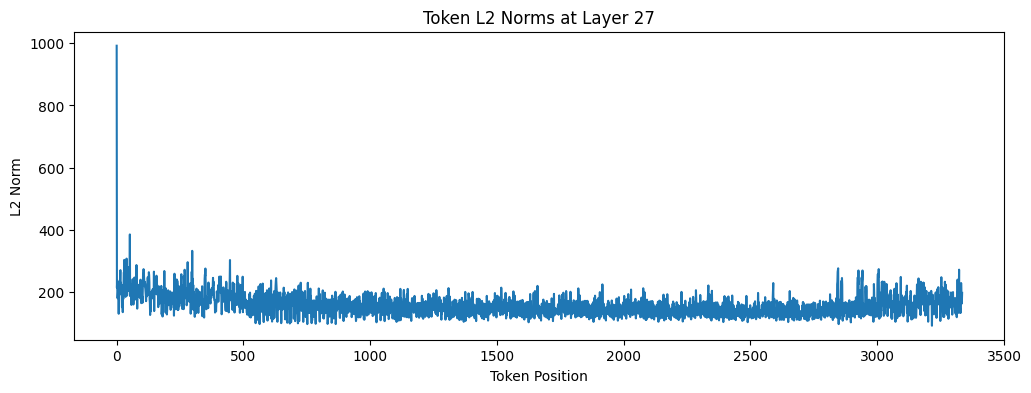

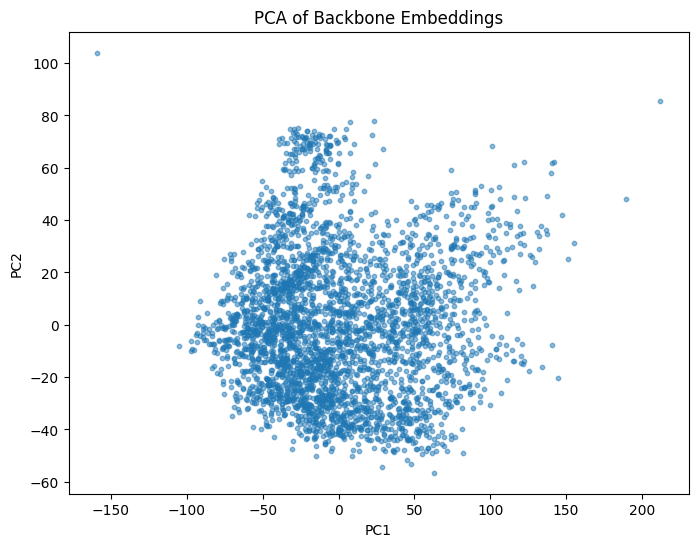

In [42]:
# --- 1. Analyze Backbone Embeddings ---
print("Extracting backbone embeddings...")

# Ensure inputs are on the correct device and dtype
device = backbone.device
target_dtype = backbone.dtype
print(f"Model device: {device}, dtype: {target_dtype}")

# Move inputs to device and cast pixel_values if needed
inputs['input_ids'] = inputs['input_ids'].to(device)
inputs['attention_mask'] = inputs['attention_mask'].to(device)
inputs['image_flags'] = inputs['image_flags'].to(device)
# Pixel values must match model dtype (e.g. bfloat16)
if inputs['pixel_values'].dtype != target_dtype:
    print(f"Casting pixel_values from {inputs['pixel_values'].dtype} to {target_dtype}")
    inputs['pixel_values'] = inputs['pixel_values'].to(device, dtype=target_dtype)
else:
    inputs['pixel_values'] = inputs['pixel_values'].to(device)

print("All inputs moved to device.")

with torch.no_grad():
    # 1. Run full backbone forward to get hidden states
    outputs = backbone(
        input_ids=inputs['input_ids'],
        attention_mask=inputs['attention_mask'],
        pixel_values=inputs['pixel_values'],
        image_flags=inputs['image_flags'],
        output_hidden_states=True,
        return_dict=True
    )
    
    # 2. Extract hidden states at cut_layer
    cut_layer = 27
    print("Backbone forward pass completed.")
    # Handle case where outputs might not be a dict (though return_dict=True should ensure it)
    if hasattr(outputs, 'hidden_states'):
        all_hidden_states = outputs.hidden_states
    elif isinstance(outputs, tuple):
        # Usually hidden_states is the 3rd element or similar in tuple output, 
        # but let's hope return_dict works. If not, we need to inspect the tuple.
        # For CausalLM: (logits, past_key_values, hidden_states, attentions)
        # So likely index 2 if past_key_values is present.
        print("Warning: outputs is a tuple, trying to find hidden_states...")
        # Heuristic: find the tuple that looks like hidden states (tuple of tensors)
        all_hidden_states = None
        for item in outputs:
            if isinstance(item, tuple) and all(isinstance(x, torch.Tensor) for x in item):
                if len(item) > 20: # Likely the hidden states (layers)
                    all_hidden_states = item
                    break
        if all_hidden_states is None:
            raise ValueError("Could not find hidden_states in outputs tuple.")
    else:
        raise ValueError(f"Unexpected outputs type: {type(outputs)}")

    print(f"Number of hidden layers available: {len(all_hidden_states)}")
    
    # hidden_states is a tuple (embeddings, layer_1, ..., layer_N)
    # layer_27 is at index 28 (0-based)
    if len(all_hidden_states) <= cut_layer + 1:
        print(f"Warning: cut_layer {cut_layer} is out of bounds. Using last layer.")
        hidden_states = all_hidden_states[-1]
    else:
        hidden_states = all_hidden_states[cut_layer + 1] # (B, Seq, Dim)
    
    print(f"Hidden states extracted. Shape: {hidden_states.shape}, Dtype: {hidden_states.dtype}")

    # Visualize L2 Norms
    # Cast to float32 before numpy conversion to handle bfloat16
    norms = hidden_states[0].float().norm(dim=-1).cpu().numpy()
    plt.figure(figsize=(12, 4))
    plt.plot(norms)
    plt.title(f"Token L2 Norms at Layer {cut_layer}")
    plt.xlabel("Token Position")
    plt.ylabel("L2 Norm")
    plt.show()
    
    # PCA of embeddings
    # Cast to float32 before numpy conversion to handle bfloat16
    embeddings_np = hidden_states[0].float().cpu().numpy()
    
    # Handle NaN/Inf just in case
    if np.isnan(embeddings_np).any() or np.isinf(embeddings_np).any():
        print("Warning: Embeddings contain NaNs or Infs. Replacing with 0 for visualization.")
        embeddings_np = np.nan_to_num(embeddings_np)

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(embeddings_np)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5, s=10)
    plt.title("PCA of Backbone Embeddings")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

Analyzing distribution for embeddings with shape (3336, 1536)...

--- Statistics ---
Min: -456.0000
Max: 474.0000
Mean: 0.0398
Std: 4.1227
Q1 (25%): -1.8047
Median (50%): 0.0312
Q3 (75%): 1.8672


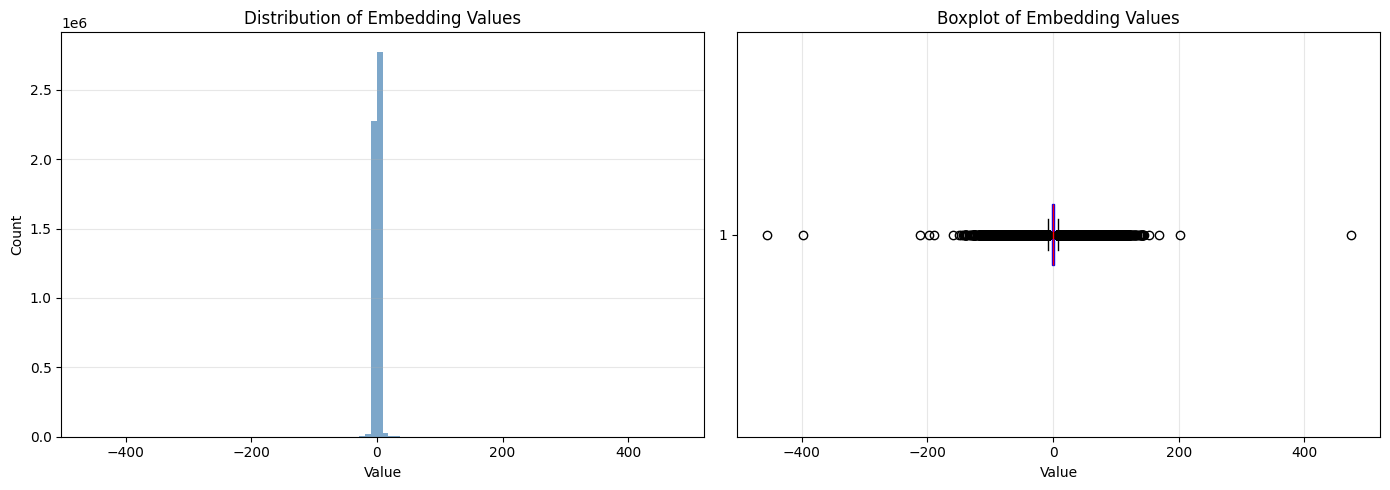

In [43]:
# --- 1.1 Backbone Embeddings Distribution ---
if 'embeddings_np' not in locals():
    print("Error: 'embeddings_np' not defined. Please run the previous cell (1. Analyze Backbone Embeddings) first.")
else:
    print(f"Analyzing distribution for embeddings with shape {embeddings_np.shape}...")
    
    # Flatten for distribution analysis
    flat_embeddings = embeddings_np.flatten()
    
    # Statistics
    stats = {
        "Min": np.min(flat_embeddings),
        "Max": np.max(flat_embeddings),
        "Mean": np.mean(flat_embeddings),
        "Std": np.std(flat_embeddings),
        "Q1 (25%)": np.percentile(flat_embeddings, 25),
        "Median (50%)": np.median(flat_embeddings),
        "Q3 (75%)": np.percentile(flat_embeddings, 75)
    }
    
    print("\n--- Statistics ---")
    for key, value in stats.items():
        print(f"{key}: {value:.4f}")
        
    # Plots
    plt.figure(figsize=(14, 5))
    
    # Histogram
    plt.subplot(1, 2, 1)
    plt.hist(flat_embeddings, bins=100, color='steelblue', alpha=0.7)
    plt.title("Distribution of Embedding Values")
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.grid(axis='y', alpha=0.3)
    
    # Boxplot
    plt.subplot(1, 2, 2)
    plt.boxplot(flat_embeddings, vert=False, patch_artist=True, 
                boxprops=dict(facecolor='lightblue', color='blue'),
                medianprops=dict(color='red'))
    plt.title("Boxplot of Embedding Values")
    plt.xlabel("Value")
    plt.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

Analyzing distribution for embeddings with shape (3336, 1536)...

--- Statistics ---
Min: -456.0000
Max: 474.0000
Mean: 0.0006
Std: 4.5644
Q1 (25%): -1.8750
Median (50%): 0.0000
Q3 (75%): 1.8672

--- Statistics ---
Min: -456.0000
Max: 474.0000
Mean: 0.0006
Std: 4.5644
Q1 (25%): -1.8750
Median (50%): 0.0000
Q3 (75%): 1.8672


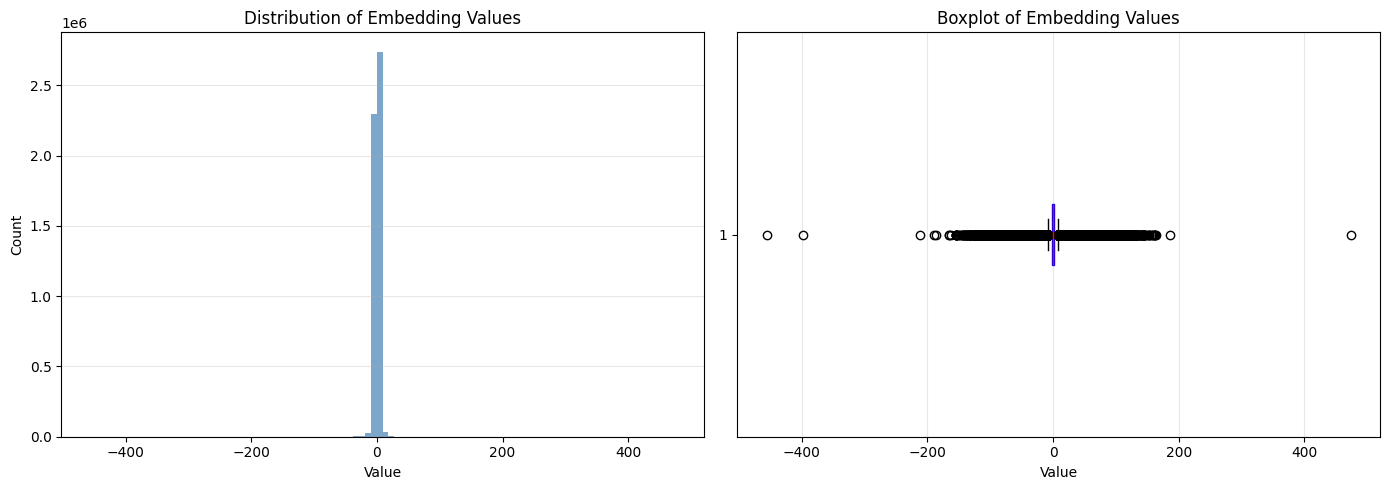

In [40]:
# --- 1.1 Backbone Embeddings Distribution ---
if 'embeddings_np' not in locals():
    print("Error: 'embeddings_np' not defined. Please run the previous cell (1. Analyze Backbone Embeddings) first.")
else:
    print(f"Analyzing distribution for embeddings with shape {embeddings_np.shape}...")
    
    # Flatten for distribution analysis
    flat_embeddings = embeddings_np.flatten()
    
    # Statistics
    stats = {
        "Min": np.min(flat_embeddings),
        "Max": np.max(flat_embeddings),
        "Mean": np.mean(flat_embeddings),
        "Std": np.std(flat_embeddings),
        "Q1 (25%)": np.percentile(flat_embeddings, 25),
        "Median (50%)": np.median(flat_embeddings),
        "Q3 (75%)": np.percentile(flat_embeddings, 75)
    }
    
    print("\n--- Statistics ---")
    for key, value in stats.items():
        print(f"{key}: {value:.4f}")
        
    # Plots
    plt.figure(figsize=(14, 5))
    
    # Histogram
    plt.subplot(1, 2, 1)
    plt.hist(flat_embeddings, bins=100, color='steelblue', alpha=0.7)
    plt.title("Distribution of Embedding Values")
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.grid(axis='y', alpha=0.3)
    
    # Boxplot
    plt.subplot(1, 2, 2)
    plt.boxplot(flat_embeddings, vert=False, patch_artist=True, 
                boxprops=dict(facecolor='lightblue', color='blue'),
                medianprops=dict(color='red'))
    plt.title("Boxplot of Embedding Values")
    plt.xlabel("Value")
    plt.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [36]:
backbone

InternVLChatModel(
  (vision_model): InternVisionModel(
    (embeddings): InternVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): InternVisionEncoder(
      (layers): ModuleList(
        (0): InternVisionEncoderLayer(
          (attn): InternAttention(
            (qkv): Linear4bit(in_features=1024, out_features=3072, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (inner_attn): FlashAttention()
            (proj): Linear4bit(in_features=1024, out_features=1024, bias=True)
          )
          (mlp): InternMLP(
            (act): GELUActivation()
            (fc1): Linear4bit(in_features=1024, out_features=4096, bias=True)
            (fc2): Linear4bit(in_features=4096, out_features=1024, bias=True)
          )
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (norm2): LayerNorm((1024,), eps=1e-06, e

Starting batch analysis for 200 documents...
Found 2560 images. Analyzing 200 samples...


100%|██████████| 200/200 [02:51<00:00,  1.16it/s]


Saved statistics to backbone_embedding_stats_200.csv

--- Aggregate Analysis (Average of Statistics) ---
Mean of Means: 0.0004
Std of Means: 0.0226
Mean of Max: 474.0000
Mean of Min: -456.0000
Mean of Q1: -1.9393
Mean of Median: 0.0087
Mean of Q3: 1.9511


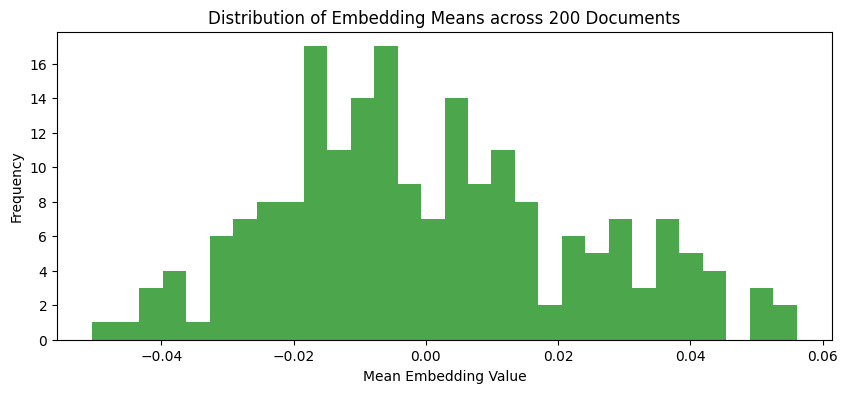

In [44]:
# --- 5. Batch Analysis (200 Samples) ---
import glob
import pandas as pd
from tqdm import tqdm

print("Starting batch analysis for 200 documents...")

# Configuration
dataset_root = "/mnt/data/rvl-cdip-small-200/train/"
num_samples = 200
output_csv = "backbone_embedding_stats_200.csv"
cut_layer = 27

# Find images
image_files = glob.glob(os.path.join(dataset_root, "**", "*.tif"), recursive=True)
if not image_files:
    print(f"No images found in {dataset_root}. Trying current directory or fallback.")
    # Fallback for testing if path doesn't exist in this env
    image_files = glob.glob("../*.tif") + glob.glob("*.jpg") 

if len(image_files) == 0:
    print("No images found. Skipping batch analysis.")
else:
    if len(image_files) > num_samples:
        # Sample randomly
        np.random.seed(42)
        sampled_files = np.random.choice(image_files, num_samples, replace=False)
    else:
        sampled_files = image_files

    print(f"Found {len(image_files)} images. Analyzing {len(sampled_files)} samples...")

    stats_list = []
    
    # Ensure model is in eval mode
    backbone.eval()
    device = backbone.device
    target_dtype = backbone.dtype

    for img_path in tqdm(sampled_files):
        try:
            # Load and prepare image
            # Note: load_image returns pixel_values. We need to handle device/dtype.
            pixel_values = load_image(img_path, max_num=12)
            
            # Prepare inputs (prompt is constant)
            inputs = prepare_inputs_for_multimodal_embedding(backbone, tokenizer, pixel_values, "Analyze this document.")
            
            # Move to device and cast
            inputs['input_ids'] = inputs['input_ids'].to(device)
            inputs['attention_mask'] = inputs['attention_mask'].to(device)
            inputs['image_flags'] = inputs['image_flags'].to(device)
            
            if inputs['pixel_values'].dtype != target_dtype:
                inputs['pixel_values'] = inputs['pixel_values'].to(device, dtype=target_dtype)
            else:
                inputs['pixel_values'] = inputs['pixel_values'].to(device)

            with torch.no_grad():
                outputs = backbone(
                    input_ids=inputs['input_ids'],
                    attention_mask=inputs['attention_mask'],
                    pixel_values=inputs['pixel_values'],
                    image_flags=inputs['image_flags'],
                    output_hidden_states=True,
                    return_dict=True
                )
                
                # Extract hidden states
                if hasattr(outputs, 'hidden_states'):
                    all_hidden_states = outputs.hidden_states
                elif isinstance(outputs, tuple):
                    # Heuristic search for hidden states tuple
                    all_hidden_states = None
                    for item in outputs:
                        if isinstance(item, tuple) and all(isinstance(x, torch.Tensor) for x in item):
                            if len(item) > 20: 
                                all_hidden_states = item
                                break
                    if all_hidden_states is None:
                        continue # Skip if failed

                if len(all_hidden_states) <= cut_layer + 1:
                    hidden_states = all_hidden_states[-1]
                else:
                    hidden_states = all_hidden_states[cut_layer + 1]

                # Calculate stats
                # Flatten embeddings for this document
                embeddings_flat = hidden_states[0].float().cpu().numpy().flatten()
                
                stats = {
                    "file": os.path.basename(img_path),
                    "min": np.min(embeddings_flat),
                    "max": np.max(embeddings_flat),
                    "mean": np.mean(embeddings_flat),
                    "std": np.std(embeddings_flat),
                    "q1": np.percentile(embeddings_flat, 25),
                    "median": np.median(embeddings_flat),
                    "q3": np.percentile(embeddings_flat, 75)
                }
                stats_list.append(stats)
                
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue

    # Create DataFrame
    if stats_list:
        df_stats = pd.DataFrame(stats_list)
        df_stats.to_csv(output_csv, index=False)
        print(f"\nSaved statistics to {output_csv}")

        # Aggregate Analysis
        print("\n--- Aggregate Analysis (Average of Statistics) ---")
        agg_stats = {
            "Mean of Means": df_stats['mean'].mean(),
            "Std of Means": df_stats['mean'].std(),
            "Mean of Max": df_stats['max'].mean(),
            "Mean of Min": df_stats['min'].mean(),
            "Mean of Q1": df_stats['q1'].mean(),
            "Mean of Median": df_stats['median'].mean(),
            "Mean of Q3": df_stats['q3'].mean()
        }

        for k, v in agg_stats.items():
            print(f"{k}: {v:.4f}")

        # Plot distribution of means
        plt.figure(figsize=(10, 4))
        plt.hist(df_stats['mean'], bins=30, color='green', alpha=0.7)
        plt.title(f"Distribution of Embedding Means across {len(df_stats)} Documents")
        plt.xlabel("Mean Embedding Value")
        plt.ylabel("Frequency")
        plt.show()
    else:
        print("No statistics collected.")

Analyzing Pooling and Projection effects on the same samples...


100%|██████████| 200/200 [02:14<00:00,  1.48it/s]
/tmp/ipykernel_72442/343775869.py:137: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(means, labels=['Backbone', 'Pooled', 'Proj', 'Final'])
/tmp/ipykernel_72442/343775869.py:144: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(stds, labels=['Backbone', 'Pooled', 'Proj', 'Final'])
/tmp/ipykernel_72442/343775869.py:156: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(ranges, labels=['Backbone', 'Pooled', 'Proj', 'Final'])



--- Comparative Analysis of Mathematical Effects ---
               Stage          Mean      Std         Min        Max      Range
         1. Backbone  3.587481e-04 4.953984 -456.000000 474.000000 930.000000
              Pooled -3.755463e-07 1.000000   -3.404922   3.205625   6.610547
Projected (Pre-Norm) -8.601525e-04 0.044184   -0.145320   0.123352   0.268672
  Final (Normalized) -8.606914e-04 0.044210   -0.145422   0.123423   0.268845


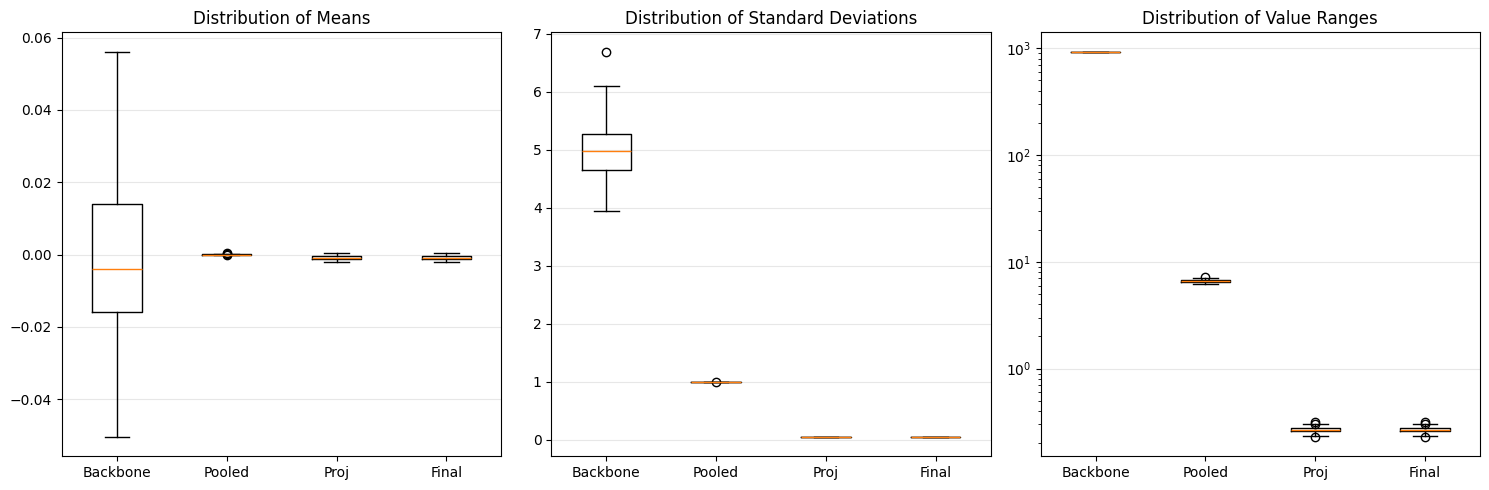

In [48]:
# --- 6. Batch Analysis: Pooling & Projection Effects ---
print("Analyzing Pooling and Projection effects on the same samples...")

if 'sampled_files' not in locals() or len(sampled_files) == 0:
    print("Error: 'sampled_files' not found. Please run the previous cell (5. Batch Analysis) first.")
else:
    # Prepare modules
    pooler = cavl_model.pool
    head = cavl_model.head
    
    device = backbone.device
    dtype = backbone.dtype
    
    pooler.to(device=device, dtype=dtype)
    head.to(device=device, dtype=dtype)
    pooler.eval()
    head.eval()

    # Storage for stats
    stage_stats = {
        "Pooled": [],
        "Projected (Pre-Norm)": [],
        "Final (Normalized)": []
    }

    for img_path in tqdm(sampled_files):
        try:
            # Re-run backbone inference (needed since we didn't save tensors)
            pixel_values = load_image(img_path, max_num=12)
            inputs = prepare_inputs_for_multimodal_embedding(backbone, tokenizer, pixel_values, "Analyze this document.")
            
            inputs['input_ids'] = inputs['input_ids'].to(device)
            inputs['attention_mask'] = inputs['attention_mask'].to(device)
            inputs['image_flags'] = inputs['image_flags'].to(device)
            if inputs['pixel_values'].dtype != dtype:
                inputs['pixel_values'] = inputs['pixel_values'].to(device, dtype=dtype)
            else:
                inputs['pixel_values'] = inputs['pixel_values'].to(device)

            with torch.no_grad():
                outputs = backbone(
                    input_ids=inputs['input_ids'],
                    attention_mask=inputs['attention_mask'],
                    pixel_values=inputs['pixel_values'],
                    image_flags=inputs['image_flags'],
                    output_hidden_states=True,
                    return_dict=True
                )
                
                # Extract hidden states (Backbone Output)
                if hasattr(outputs, 'hidden_states'):
                    all_hidden_states = outputs.hidden_states
                elif isinstance(outputs, tuple):
                    all_hidden_states = [x for x in outputs if isinstance(x, tuple) and len(x) > 20][0]

                if len(all_hidden_states) <= cut_layer + 1:
                    hidden_states = all_hidden_states[-1]
                else:
                    hidden_states = all_hidden_states[cut_layer + 1]
                
                # --- New Stages ---
                
                # 1. Pooling
                # hidden_states: (B, Seq, Dim)
                pooled = pooler(hidden_states, mask=inputs['attention_mask'])
                
                # 2. Projection (Head)
                # Assuming head forward is the MLP
                projected = head(pooled)
                
                # 3. Normalization
                final = F.normalize(projected, dim=-1)
                
                # Helper to get stats
                def get_stats(tensor):
                    flat = tensor.float().cpu().numpy().flatten()
                    return {
                        "mean": np.mean(flat),
                        "std": np.std(flat),
                        "min": np.min(flat),
                        "max": np.max(flat),
                        "q1": np.percentile(flat, 25),
                        "median": np.median(flat),
                        "q3": np.percentile(flat, 75)
                    }
                
                stage_stats["Pooled"].append(get_stats(pooled))
                stage_stats["Projected (Pre-Norm)"].append(get_stats(projected))
                stage_stats["Final (Normalized)"].append(get_stats(final))

        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue

    # Aggregate and Display
    results_df = {}
    
    print("\n--- Comparative Analysis of Mathematical Effects ---")
    
    # We also have backbone stats from previous cell in df_stats
    # Let's create a summary table
    
    summary_data = []
    
    # Add Backbone (from previous cell df_stats)
    if 'df_stats' in locals():
        summary_data.append({
            "Stage": "1. Backbone",
            "Mean": df_stats['mean'].mean(),
            "Std": df_stats['std'].mean(), # Average of stds (approx)
            "Min": df_stats['min'].mean(),
            "Max": df_stats['max'].mean(),
            "Range": df_stats['max'].mean() - df_stats['min'].mean()
        })
    
    for stage_name, stats_list in stage_stats.items():
        df = pd.DataFrame(stats_list)
        results_df[stage_name] = df
        summary_data.append({
            "Stage": stage_name,
            "Mean": df['mean'].mean(),
            "Std": df['std'].mean(),
            "Min": df['min'].mean(),
            "Max": df['max'].mean(),
            "Range": df['max'].mean() - df['min'].mean()
        })
        
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))
    
    # Visual Comparison
    plt.figure(figsize=(15, 5))
    
    # Plot Means
    plt.subplot(1, 3, 1)
    means = [df_stats['mean'], results_df['Pooled']['mean'], results_df['Projected (Pre-Norm)']['mean'], results_df['Final (Normalized)']['mean']]
    plt.boxplot(means, labels=['Backbone', 'Pooled', 'Proj', 'Final'])
    plt.title("Distribution of Means")
    plt.grid(axis='y', alpha=0.3)
    
    # Plot Stds
    plt.subplot(1, 3, 2)
    stds = [df_stats['std'], results_df['Pooled']['std'], results_df['Projected (Pre-Norm)']['std'], results_df['Final (Normalized)']['std']]
    plt.boxplot(stds, labels=['Backbone', 'Pooled', 'Proj', 'Final'])
    plt.title("Distribution of Standard Deviations")
    plt.grid(axis='y', alpha=0.3)
    
    # Plot Ranges (Log scale maybe needed)
    plt.subplot(1, 3, 3)
    ranges = [
        df_stats['max'] - df_stats['min'],
        results_df['Pooled']['max'] - results_df['Pooled']['min'],
        results_df['Projected (Pre-Norm)']['max'] - results_df['Projected (Pre-Norm)']['min'],
        results_df['Final (Normalized)']['max'] - results_df['Final (Normalized)']['min']
    ]
    plt.boxplot(ranges, labels=['Backbone', 'Pooled', 'Proj', 'Final'])
    plt.title("Distribution of Value Ranges")
    plt.yscale('log')
    plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

Simulating with synthetic data based on backbone statistics...
Generating synthetic data: Normal(mean=0.0004, std=0.0226)...
Forward pass complete. Pooled shape: torch.Size([100, 1536])


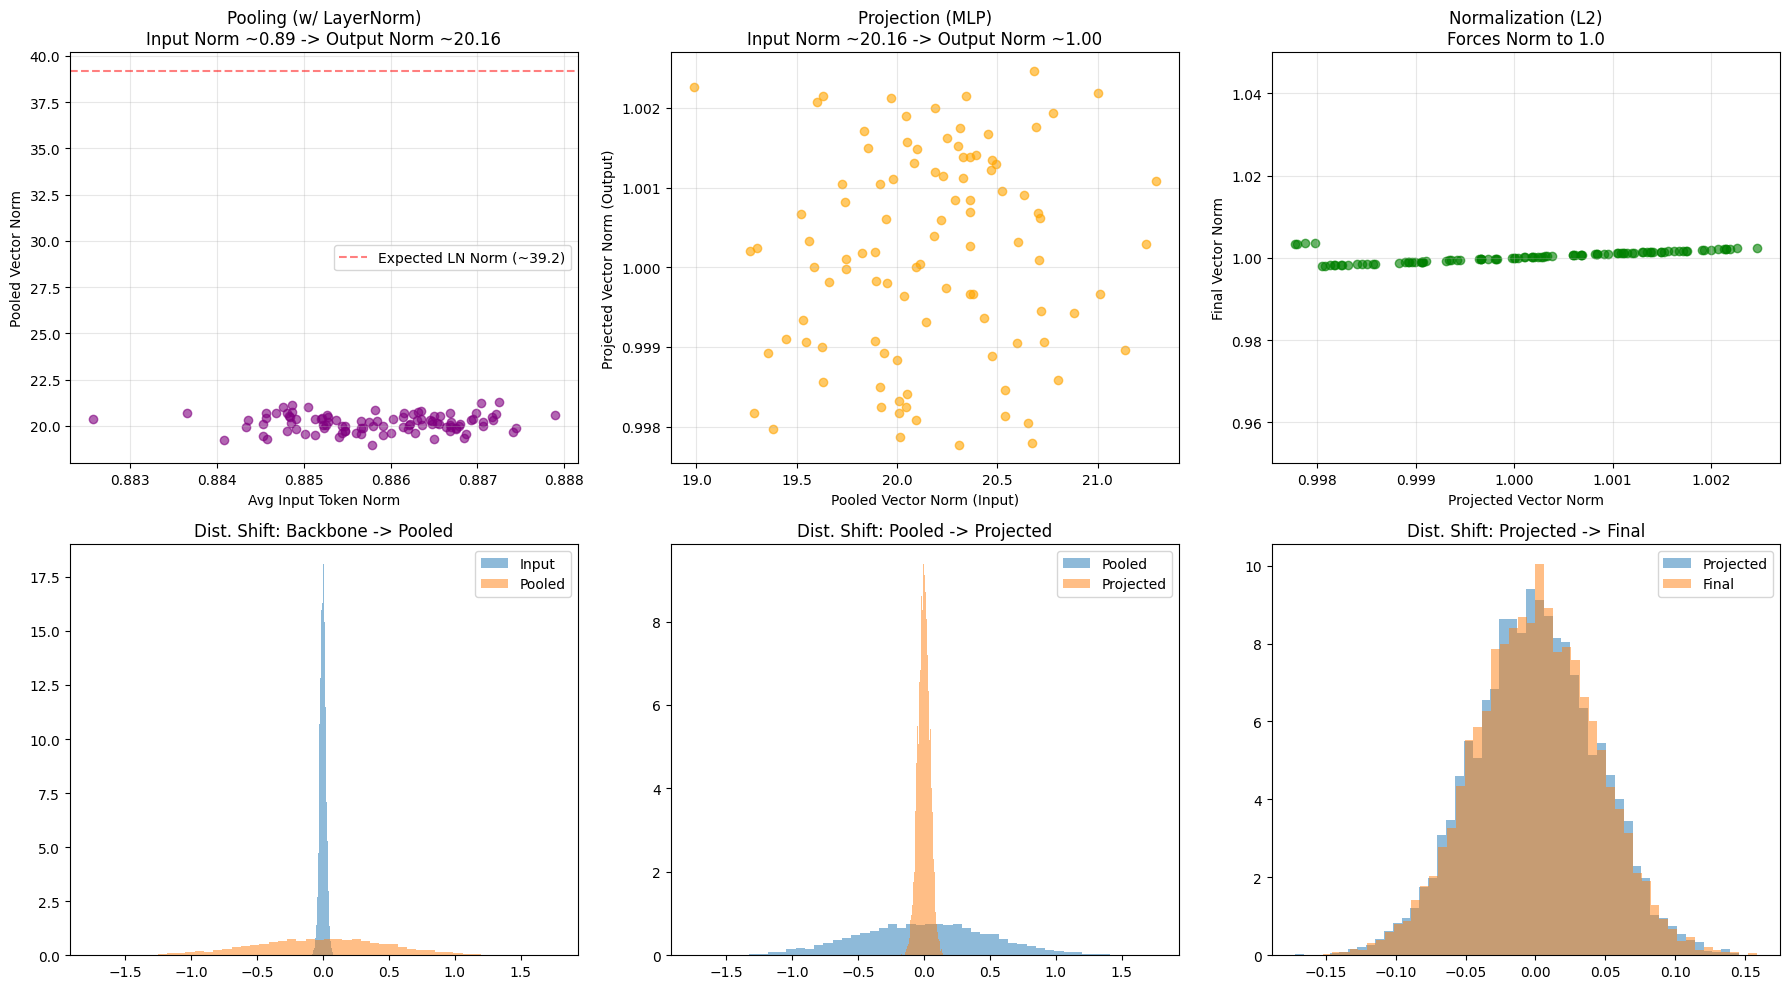

In [54]:
# --- 7. Simulation with Synthetic Data (y = f(x) Analysis) ---
print("Simulating with synthetic data based on backbone statistics...")

# Ensure we have the necessary objects defined in this scope
if 'cavl_model' in locals():
    pooler = cavl_model.pool
    head = cavl_model.head
    device = cavl_model.device
    dtype = cavl_model.dtype
else:
    # Fallback if run out of order (assuming variables exist globally)
    device = backbone.device
    dtype = backbone.dtype

# 1. Define Statistics (from previous analysis)
# Using the values observed: Mean ~ 0.0004, Std ~ 0.0226
sim_mean = 0.0004
sim_std = 0.0226

# Dimensions
batch_size = 100
seq_len = 256 # Typical number of patches
hidden_dim = 1536 # InternVL hidden dim

# 2. Generate Synthetic Data
print(f"Generating synthetic data: Normal(mean={sim_mean}, std={sim_std})...")
# Shape: (Batch, Seq, Dim)
synthetic_inputs = torch.randn(batch_size, seq_len, hidden_dim, device=device, dtype=dtype) * sim_std + sim_mean

# Create a dummy mask (all ones, no padding)
synthetic_mask = torch.ones((batch_size, seq_len), device=device, dtype=torch.long)

# 3. Run Modules
pooler.eval()
head.eval()

with torch.no_grad():
    # A. Pooling
    # Input: (B, S, D) -> Output: (B, D) (Since num_queries=1)
    pooled_output = pooler(synthetic_inputs, mask=synthetic_mask)
    
    # B. Projection
    # Input: (B, D) -> Output: (B, Proj_Dim)
    projected_output = head(pooled_output)
    
    # C. Normalization
    final_output = F.normalize(projected_output, dim=-1)

print(f"Forward pass complete. Pooled shape: {pooled_output.shape}")

# 4. Visualize "y = f(x)" Effects
plt.figure(figsize=(18, 10))

# --- Plot 1: Pooling Effect (Input Energy vs Output Energy) ---
# We compare the average norm of input tokens vs norm of the pooled vector
in_norms_pool = synthetic_inputs.float().norm(dim=-1).mean(dim=1).cpu().numpy() # (B,)
out_norms_pool = pooled_output.float().norm(dim=-1).cpu().numpy()               # (B,)

# Theoretical expected norm for LayerNorm output: sqrt(dim)
expected_norm = np.sqrt(hidden_dim)

plt.subplot(2, 3, 1)
plt.scatter(in_norms_pool, out_norms_pool, alpha=0.6, c='purple')
plt.title(f"Pooling (w/ LayerNorm)\nInput Norm ~{in_norms_pool.mean():.2f} -> Output Norm ~{out_norms_pool.mean():.2f}")
plt.xlabel("Avg Input Token Norm")
plt.ylabel("Pooled Vector Norm")
plt.axhline(y=expected_norm, color='r', linestyle='--', alpha=0.5, label=f'Expected LN Norm (~{expected_norm:.1f})')
plt.grid(True, alpha=0.3)
plt.legend()
# Note: We removed the y=x line because LayerNorm drastically changes the scale (from ~0.9 to ~39)

# --- Plot 2: Projection Effect (Input Norm vs Output Norm) ---
# Does the MLP expand the vector magnitude?
in_norms_proj = pooled_output.float().norm(dim=-1).flatten().cpu().numpy() # (B,)
out_norms_proj = projected_output.float().norm(dim=-1).flatten().cpu().numpy() # (B,)

plt.subplot(2, 3, 2)
plt.scatter(in_norms_proj, out_norms_proj, alpha=0.6, c='orange')
plt.title(f"Projection (MLP)\nInput Norm ~{in_norms_proj.mean():.2f} -> Output Norm ~{out_norms_proj.mean():.2f}")
plt.xlabel("Pooled Vector Norm (Input)")
plt.ylabel("Projected Vector Norm (Output)")
plt.grid(True, alpha=0.3)

# --- Plot 3: Normalization Effect (Input Norm vs Output Norm) ---
# Should flatten everything to 1
in_norms_final = projected_output.float().norm(dim=-1).flatten().cpu().numpy()
out_norms_final = final_output.float().norm(dim=-1).flatten().cpu().numpy()

plt.subplot(2, 3, 3)
plt.scatter(in_norms_final, out_norms_final, alpha=0.6, c='green')
plt.title("Normalization (L2)\nForces Norm to 1.0")
plt.xlabel("Projected Vector Norm")
plt.ylabel("Final Vector Norm")
plt.ylim(0.95, 1.05) # Zoom in to show it's exactly 1.0
plt.grid(True, alpha=0.3)

# --- Plot 4, 5, 6: Value Distributions (Histograms) ---
# Sample points for cleaner histograms
num_points = 10000
flat_in = synthetic_inputs.float().cpu().numpy().flatten()
flat_pool = pooled_output.float().cpu().numpy().flatten()
flat_proj = projected_output.float().cpu().numpy().flatten()
flat_final = final_output.float().cpu().numpy().flatten()

# Ensure we don't sample more than available
num_points = min(num_points, len(flat_pool))

idx_in = np.random.choice(len(flat_in), num_points)
idx_pool = np.random.choice(len(flat_pool), num_points)
idx_proj = np.random.choice(len(flat_proj), num_points)
idx_final = np.random.choice(len(flat_final), num_points)

plt.subplot(2, 3, 4)
plt.hist(flat_in[idx_in], bins=50, alpha=0.5, label='Input', density=True)
plt.hist(flat_pool[idx_pool], bins=50, alpha=0.5, label='Pooled', density=True)
plt.legend()
plt.title("Dist. Shift: Backbone -> Pooled")

plt.subplot(2, 3, 5)
plt.hist(flat_pool[idx_pool], bins=50, alpha=0.5, label='Pooled', density=True)
plt.hist(flat_proj[idx_proj], bins=50, alpha=0.5, label='Projected', density=True)
plt.legend()
plt.title("Dist. Shift: Pooled -> Projected")

plt.subplot(2, 3, 6)
plt.hist(flat_proj[idx_proj], bins=50, alpha=0.5, label='Projected', density=True)
plt.hist(flat_final[idx_final], bins=50, alpha=0.5, label='Final', density=True)
plt.legend()
plt.title("Dist. Shift: Projected -> Final")

plt.tight_layout()
plt.show()

Simulating structured data (clusters) to visualize geometric transformations...


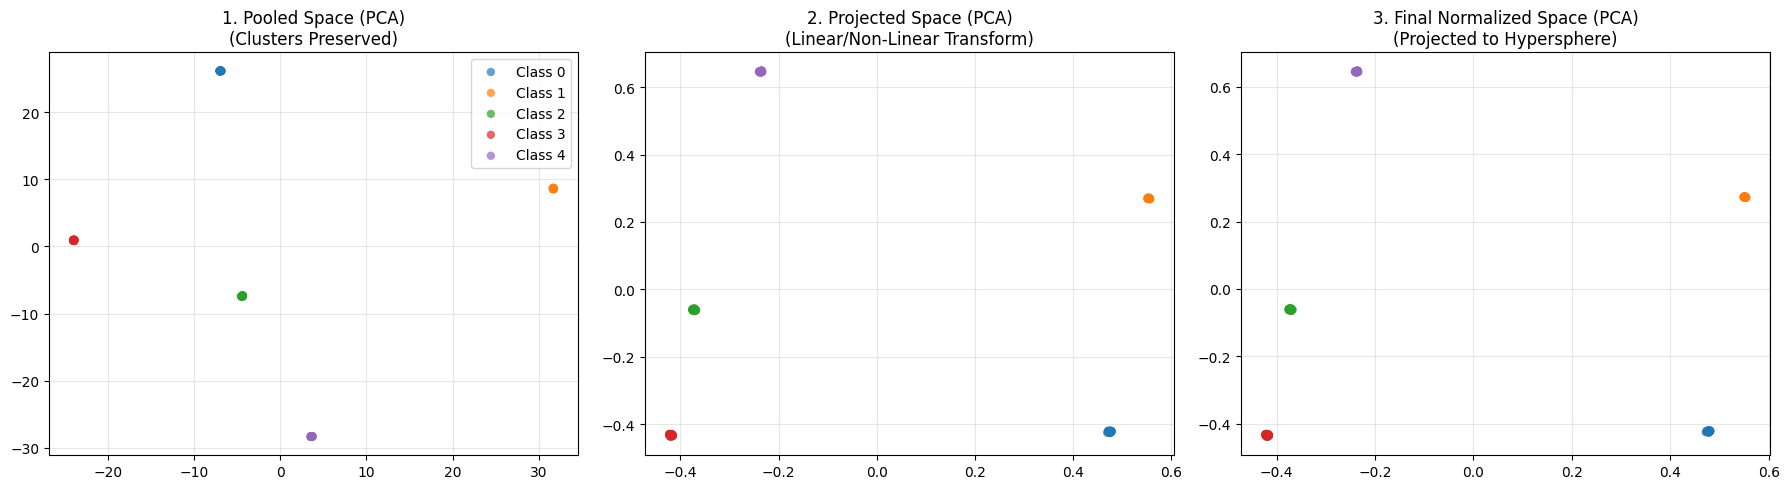

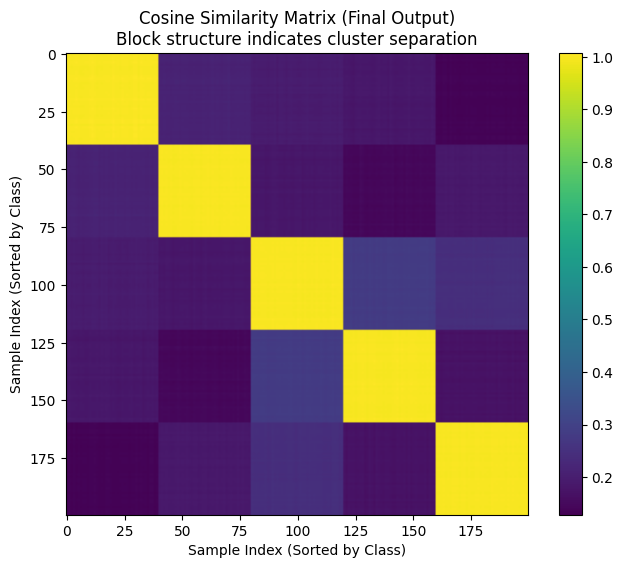

In [55]:
# --- 8. Geometric Analysis with Structured Synthetic Data ---
print("Simulating structured data (clusters) to visualize geometric transformations...")

from sklearn.decomposition import PCA

# 1. Generate Structured Data (Clusters)
# To visualize geometry, we need structure. We'll create synthetic "classes".
num_classes = 5
samples_per_class = 40
n_samples = num_classes * samples_per_class
hidden_dim = 1536
seq_len = 256

# Create random class centroids in the input space
centroids = torch.randn(num_classes, hidden_dim, device=device, dtype=dtype)

# Generate samples around centroids
# Input = Centroid + Random Noise per patch
inputs_list = []
labels = []
for i in range(num_classes):
    # Centroid for class i
    c = centroids[i].unsqueeze(0).unsqueeze(0) # (1, 1, D)
    
    # Noise (smaller std to keep clusters tight)
    noise = torch.randn(samples_per_class, seq_len, hidden_dim, device=device, dtype=dtype) * 0.5 
    
    # Samples
    class_samples = c + noise
    inputs_list.append(class_samples)
    labels.extend([i] * samples_per_class)

synthetic_inputs_structured = torch.cat(inputs_list, dim=0) # (N, S, D)
synthetic_mask_structured = torch.ones((n_samples, seq_len), device=device, dtype=torch.long)
labels = np.array(labels)

# 2. Run Forward Pass
pooler.eval()
head.eval()

with torch.no_grad():
    # A. Pooling
    pooled = pooler(synthetic_inputs_structured, mask=synthetic_mask_structured)
    
    # B. Projection
    proj = head(pooled)
    
    # C. Normalization
    final = F.normalize(proj, dim=-1)

# 3. Visualization (PCA)
def plot_pca(tensor, title, ax):
    data = tensor.float().cpu().numpy()
    pca = PCA(n_components=2)
    result = pca.fit_transform(data)
    
    for i in range(num_classes):
        mask = labels == i
        ax.scatter(result[mask, 0], result[mask, 1], label=f'Class {i}', alpha=0.7, edgecolors='none')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)

plt.figure(figsize=(18, 5))

# Plot 1: Pooled Space
ax1 = plt.subplot(1, 3, 1)
plot_pca(pooled, "1. Pooled Space (PCA)\n(Clusters Preserved)", ax1)
ax1.legend()

# Plot 2: Projected Space
ax2 = plt.subplot(1, 3, 2)
plot_pca(proj, "2. Projected Space (PCA)\n(Linear/Non-Linear Transform)", ax2)

# Plot 3: Final Space (Normalized)
ax3 = plt.subplot(1, 3, 3)
plot_pca(final, "3. Final Normalized Space (PCA)\n(Projected to Hypersphere)", ax3)

plt.tight_layout()
plt.show()

# 4. Cosine Similarity Matrix
# To show geometry in terms of angles
final_np = final.float().cpu().numpy()
sim_matrix = np.dot(final_np, final_np.T)

plt.figure(figsize=(8, 6))
plt.imshow(sim_matrix, cmap='viridis')
plt.title("Cosine Similarity Matrix (Final Output)\nBlock structure indicates cluster separation")
plt.xlabel("Sample Index (Sorted by Class)")
plt.ylabel("Sample Index (Sorted by Class)")
plt.colorbar()
plt.show()

Visualizing the Expansion-Compression architecture of the Projection Head...


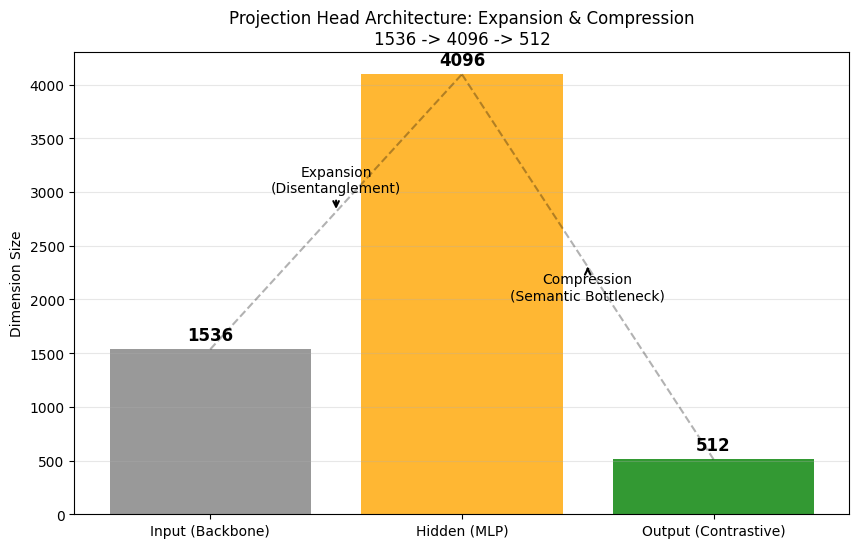

In [56]:
# --- 9. Architecture Dimensions Visualization (Bottleneck Analysis) ---
print("Visualizing the Expansion-Compression architecture of the Projection Head...")

# Dimensions defined in your model
dim_input = 1536  # Backbone Output
dim_hidden = 4096 # MLP Hidden Layer (Expansion)
dim_output = 512  # Final Embedding (Compression)

layer_names = ['Input (Backbone)', 'Hidden (MLP)', 'Output (Contrastive)']
layer_dims = [dim_input, dim_hidden, dim_output]

plt.figure(figsize=(10, 6))

# Bar chart
bars = plt.bar(layer_names, layer_dims, color=['gray', 'orange', 'green'], alpha=0.8)

# Add values on top
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 50,
             f'{height}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Draw connections to show flow
plt.plot([0, 1], [dim_input, dim_hidden], 'k--', alpha=0.3)
plt.plot([1, 2], [dim_hidden, dim_output], 'k--', alpha=0.3)

plt.title(f"Projection Head Architecture: Expansion & Compression\n{dim_input} -> {dim_hidden} -> {dim_output}")
plt.ylabel("Dimension Size")
plt.grid(axis='y', alpha=0.3)

# Add annotation about the "Bottleneck"
plt.annotate('Expansion\n(Disentanglement)', xy=(0.5, (dim_input+dim_hidden)/2), 
             xytext=(0.5, 3000), ha='center', arrowprops=dict(arrowstyle='->', lw=1.5))

plt.annotate('Compression\n(Semantic Bottleneck)', xy=(1.5, (dim_hidden+dim_output)/2), 
             xytext=(1.5, 2000), ha='center', arrowprops=dict(arrowstyle='->', lw=1.5))

plt.show()

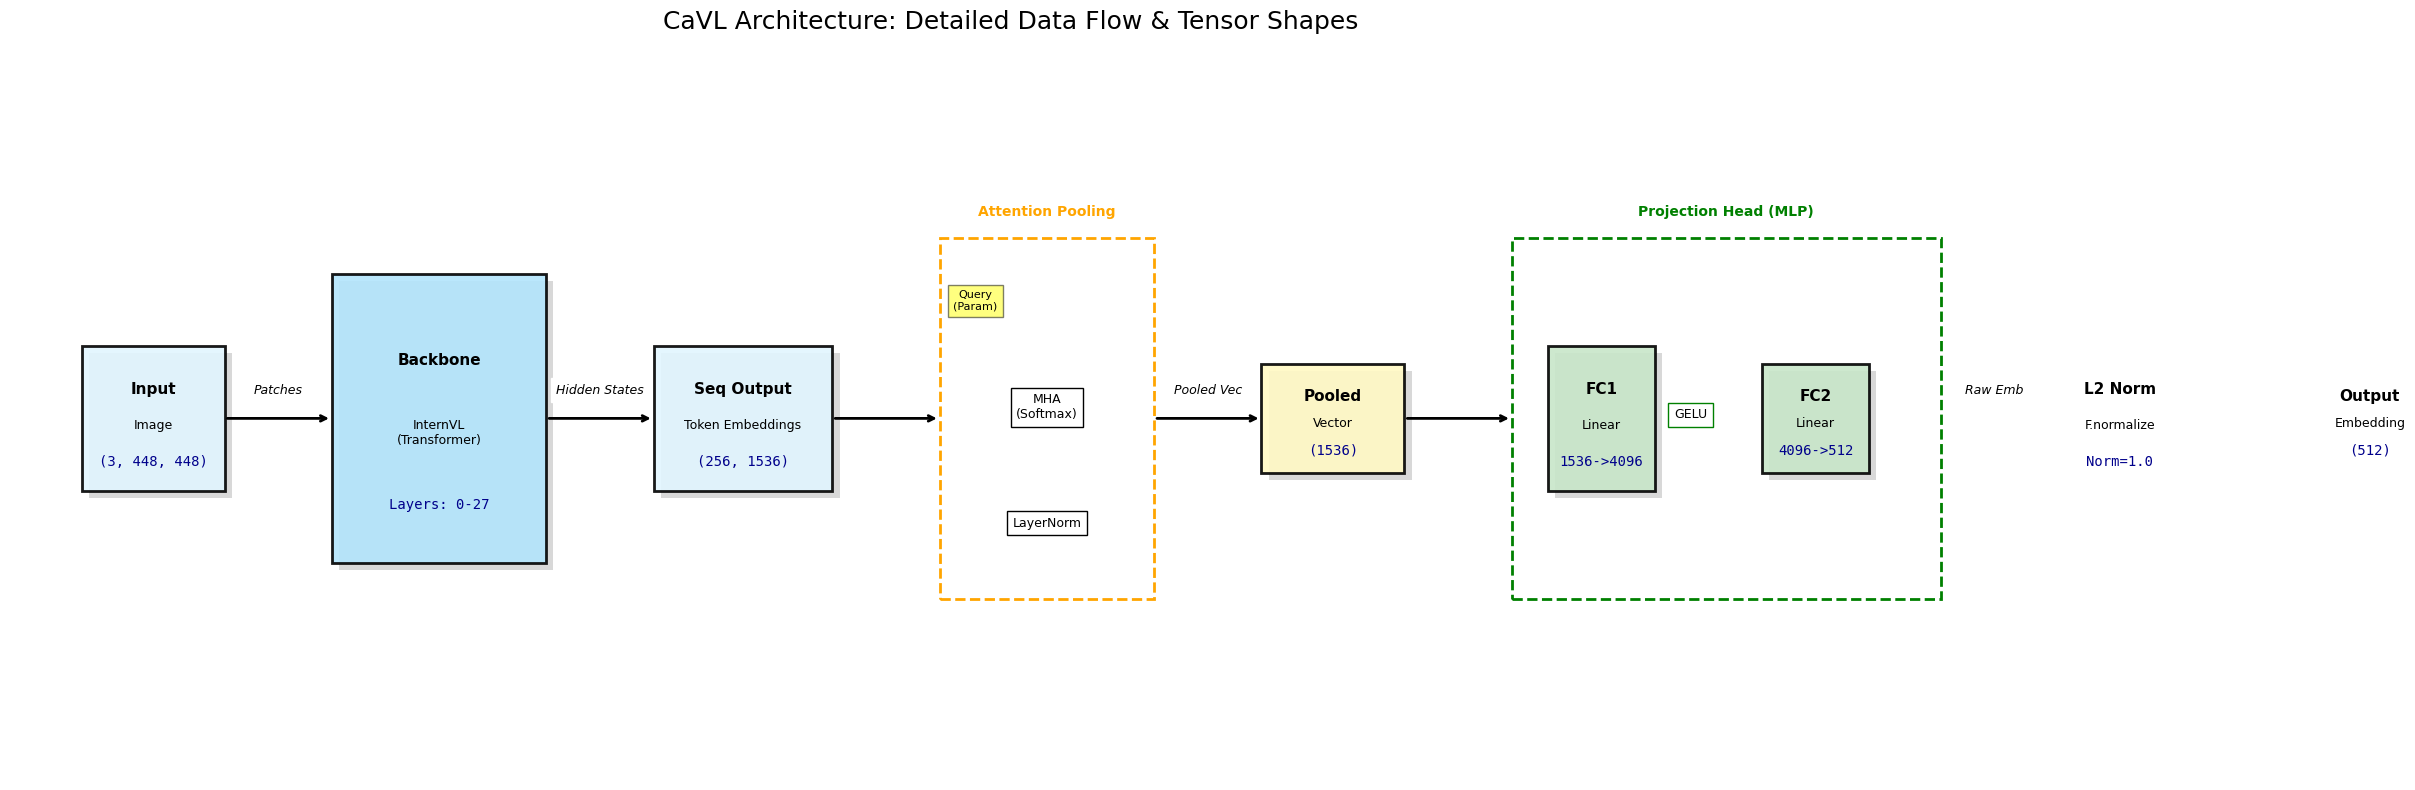

In [59]:
# --- 10. Detailed Architecture Pipeline Visualization ---
import matplotlib.patches as patches

def draw_detailed_pipeline():
    fig, ax = plt.subplots(figsize=(24, 8))
    ax.set_xlim(0, 28)
    ax.set_ylim(0, 10)
    ax.axis('off')

    # Helper to draw box
    def draw_box(x, y, w, h, color, label, sublabel="", shape=""):
        # Shadow
        shadow = patches.Rectangle((x+0.1, y-0.1), w, h, linewidth=0, facecolor='gray', alpha=0.3)
        ax.add_patch(shadow)
        # Box
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='black', facecolor=color, alpha=0.9)
        # Use FancyBboxPatch for rounded corners if desired, but Rectangle is simpler for now
        ax.add_patch(rect)
        
        # Text
        ax.text(x + w/2, y + h*0.7, label, ha='center', va='center', fontsize=11, fontweight='bold')
        if sublabel:
            ax.text(x + w/2, y + h*0.45, sublabel, ha='center', va='center', fontsize=9)
        if shape:
            ax.text(x + w/2, y + h*0.2, shape, ha='center', va='center', fontsize=10, fontfamily='monospace', color='darkblue')
        return x + w, y + h/2

    # Helper to draw arrow
    def draw_arrow(x1, y1, x2, y2, label=""):
        ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                    arrowprops=dict(arrowstyle='->', lw=2, color='black'))
        if label:
            ax.text((x1+x2)/2, y1 + 0.3, label, ha='center', va='bottom', fontsize=9, style='italic', backgroundcolor='white')

    # --- 1. Input ---
    x_curr = 1
    x_curr, y_mid = draw_box(x_curr, 4, 2, 2, '#E1F5FE', "Input", "Image", "(3, 448, 448)")
    
    draw_arrow(x_curr, y_mid, x_curr+1.5, y_mid, "Patches")
    x_curr += 1.5

    # --- 2. Backbone ---
    x_curr, y_mid = draw_box(x_curr, 3, 3, 4, '#B3E5FC', "Backbone", "InternVL\n(Transformer)", "Layers: 0-27")
    
    draw_arrow(x_curr, y_mid, x_curr+1.5, y_mid, "Hidden States")
    x_curr += 1.5

    # --- 3. Sequence Output ---
    x_curr, y_mid = draw_box(x_curr, 4, 2.5, 2, '#E1F5FE', "Seq Output", "Token Embeddings", "(256, 1536)")
    
    draw_arrow(x_curr, y_mid, x_curr+1.5, y_mid)
    x_curr += 1.5

    # --- 4. Pooler ---
    # Draw Pooler as a container
    pooler_x = x_curr
    pooler_w = 3
    pooler_rect = patches.Rectangle((pooler_x, 2.5), pooler_w, 5, linewidth=2, edgecolor='orange', facecolor='none', linestyle='--')
    ax.add_patch(pooler_rect)
    ax.text(pooler_x + pooler_w/2, 7.8, "Attention Pooling", ha='center', fontsize=10, color='orange', fontweight='bold')

    # Query
    ax.text(pooler_x + 0.5, 6.5, "Query\n(Param)", ha='center', fontsize=8, bbox=dict(facecolor='yellow', alpha=0.5))
    # Attention Operation
    ax.text(pooler_x + 1.5, 5, "MHA\n(Softmax)", ha='center', fontsize=9, bbox=dict(facecolor='white', edgecolor='black'))
    # LayerNorm
    ax.text(pooler_x + 1.5, 3.5, "LayerNorm", ha='center', fontsize=9, bbox=dict(facecolor='white', edgecolor='black'))
    
    x_curr += pooler_w
    y_mid = 5 # Reset y_mid to center
    
    draw_arrow(x_curr, y_mid, x_curr+1.5, y_mid, "Pooled Vec")
    x_curr += 1.5

    # --- 5. Pooled Vector ---
    x_curr, y_mid = draw_box(x_curr, 4.25, 2, 1.5, '#FFF9C4', "Pooled", "Vector", "(1536)")
    
    draw_arrow(x_curr, y_mid, x_curr+1.5, y_mid)
    x_curr += 1.5

    # --- 6. Projection Head (Detailed) ---
    # Container
    head_x = x_curr
    head_w = 6
    head_rect = patches.Rectangle((head_x, 2.5), head_w, 5, linewidth=2, edgecolor='green', facecolor='none', linestyle='--')
    ax.add_patch(head_rect)
    ax.text(head_x + head_w/2, 7.8, "Projection Head (MLP)", ha='center', fontsize=10, color='green', fontweight='bold')

    # FC1 (Expansion)
    draw_box(head_x + 0.5, 4, 1.5, 2, '#C8E6C9', "FC1", "Linear", "1536->4096")
    
    # GELU
    ax.text(head_x + 2.5, 5, "GELU", ha='center', fontsize=9, bbox=dict(facecolor='white', edgecolor='green'))
    
    # FC2 (Compression)
    draw_box(head_x + 3.5, 4.25, 1.5, 1.5, '#C8E6C9', "FC2", "Linear", "4096->512")

    x_curr += head_w
    
    draw_arrow(x_curr, y_mid, x_curr+1.5, y_mid, "Raw Emb")
    x_curr += 1.5

    # --- 7. Normalization ---
    x_curr, y_mid = draw_box(x_curr, 4, 2, 2, '#F8BBD0', "L2 Norm", "F.normalize", "Norm=1.0")
    
    draw_arrow(x_curr, y_mid, x_curr+1.5, y_mid)
    x_curr += 1.5

    # --- 8. Final Output ---
    x_curr, y_mid = draw_box(x_curr, 4.25, 2, 1.5, '#FFCC80', "Output", "Embedding", "(512)")

    plt.title("CaVL Architecture: Detailed Data Flow & Tensor Shapes", fontsize=18, pad=20)
    plt.tight_layout()
    plt.show()

draw_detailed_pipeline()

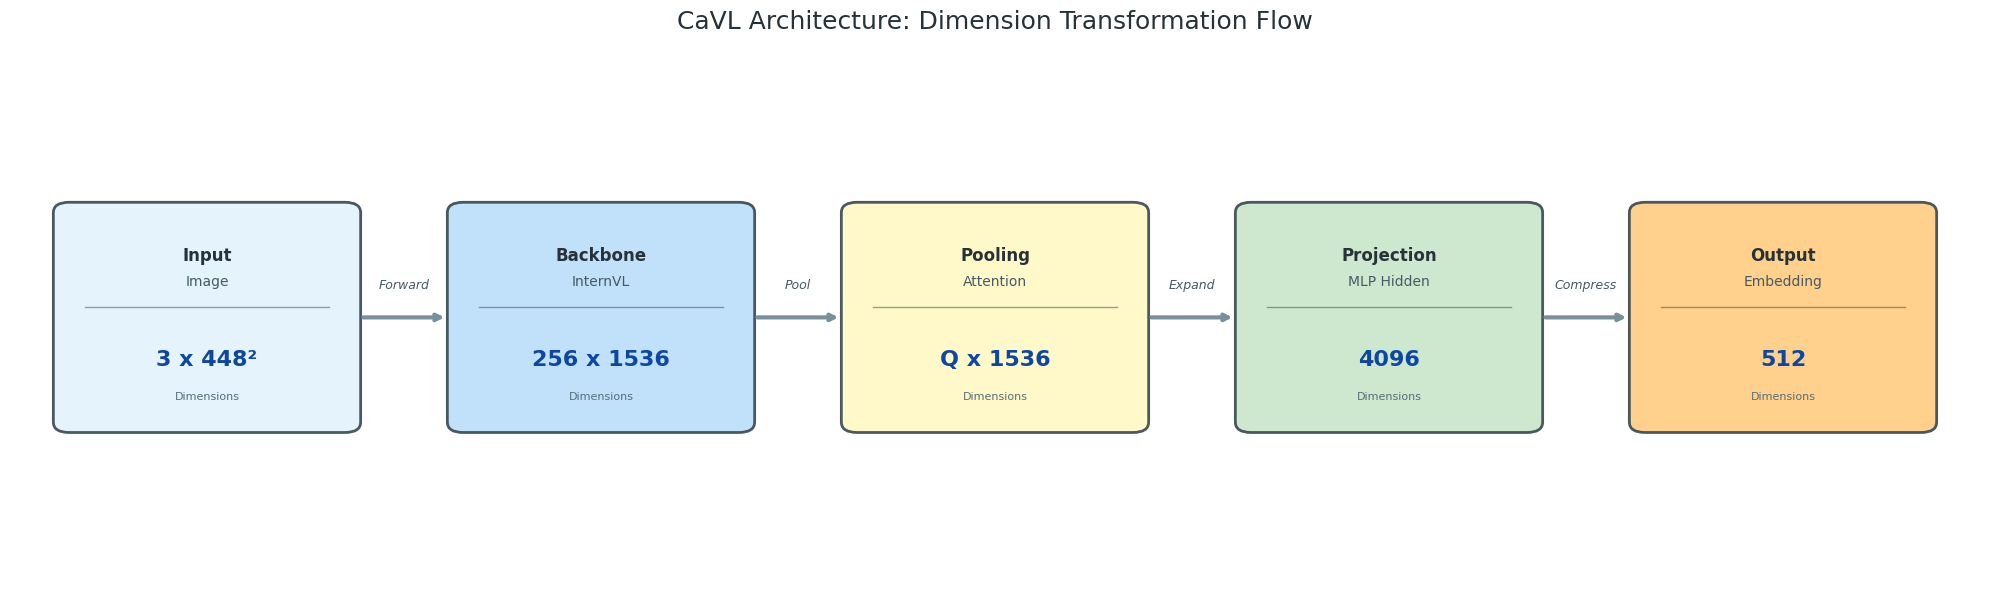

In [1]:
# --- 11. Infographic: Dimension Flow ---
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_infographic_flow():
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.set_xlim(0, 25)
    ax.set_ylim(0, 10)
    ax.axis('off')
    
    # Define the flow nodes
    # (Label, Sublabel, Dimension/Shape, Color, x_pos)
    nodes = [
        ("Input", "Image", "3 x 448²", "#E3F2FD", 2.5),
        ("Backbone", "InternVL", "256 x 1536", "#BBDEFB", 7.5),
        ("Pooling", "Attention", "Q x 1536", "#FFF9C4", 12.5),
        ("Projection", "MLP Hidden", "4096", "#C8E6C9", 17.5),
        ("Output", "Embedding", "512", "#FFCC80", 22.5)
    ]
    
    y_center = 5
    
    for i, (label, sublabel, shape, color, x) in enumerate(nodes):
        # Draw Card for the node
        box_w, box_h = 3.5, 4
        rect = patches.FancyBboxPatch((x - box_w/2, y_center - box_h/2), box_w, box_h, 
                                      boxstyle="round,pad=0.2", 
                                      linewidth=2, edgecolor='#37474F', facecolor=color, alpha=0.9)
        ax.add_patch(rect)
        
        # Label (Top)
        ax.text(x, y_center + 1.2, label, ha='center', va='center', fontsize=12, fontweight='bold', color='#263238')
        ax.text(x, y_center + 0.7, sublabel, ha='center', va='center', fontsize=10, color='#455A64')
        
        # Divider line
        ax.plot([x - box_w/2 + 0.2, x + box_w/2 - 0.2], [y_center + 0.2, y_center + 0.2], color='#37474F', lw=1, alpha=0.5)
        
        # Shape (Center - Big)
        ax.text(x, y_center - 0.8, shape, ha='center', va='center', fontsize=16, fontfamily='sans-serif', fontweight='bold', color='#0D47A1')
        ax.text(x, y_center - 1.5, "Dimensions", ha='center', va='center', fontsize=8, color='#546E7A')
        
        # Draw Arrow to next
        if i < len(nodes) - 1:
            next_x = nodes[i+1][4]
            # Arrow start and end
            arrow_start = x + box_w/2 + 0.2
            arrow_end = next_x - box_w/2 - 0.2
            
            ax.annotate("", xy=(arrow_end, y_center), xytext=(arrow_start, y_center),
                        arrowprops=dict(arrowstyle="->", lw=3, color="#78909C"))
            
            # Operation Label between nodes
            op_label = ""
            if i == 0: op_label = "Forward"
            elif i == 1: op_label = "Pool"
            elif i == 2: op_label = "Expand"
            elif i == 3: op_label = "Compress"
            
            ax.text((arrow_start + arrow_end)/2, y_center + 0.5, op_label, ha='center', va='bottom', fontsize=9, style='italic', color='#455A64')

    plt.title("CaVL Architecture: Dimension Transformation Flow", fontsize=18, pad=20, color='#263238')
    plt.tight_layout()
    plt.show()

draw_infographic_flow()

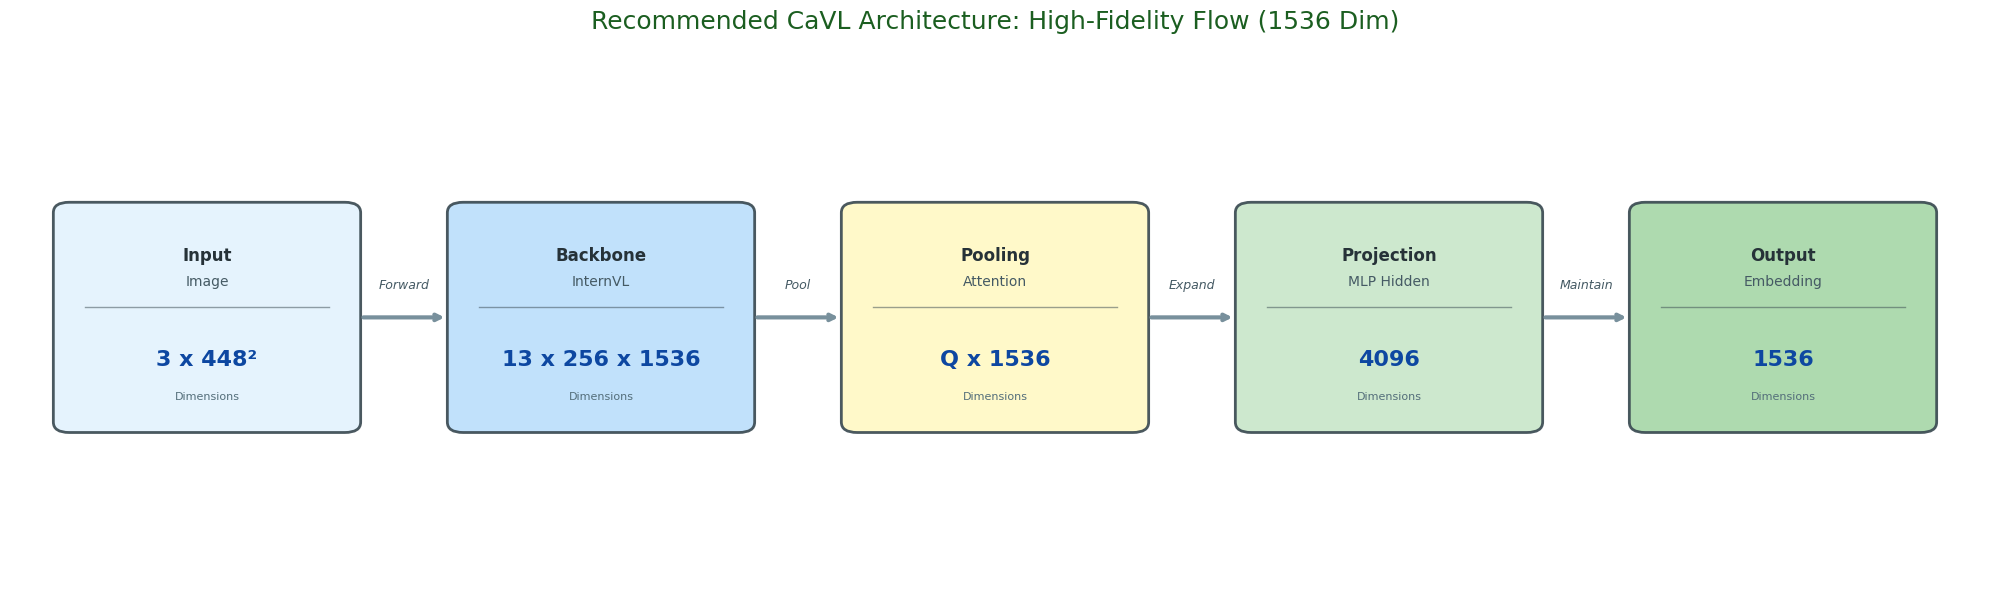

In [6]:
# --- 13. Updated Architecture Recommendation (Infographic) ---
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_recommended_flow():
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.set_xlim(0, 25)
    ax.set_ylim(0, 10)
    ax.axis('off')
    
    # Define the flow nodes for the RECOMMENDED architecture
    nodes = [
        ("Input", "Image", "3 x 448²", "#E3F2FD", 2.5),
        ("Backbone", "InternVL", "13 x 256 x 1536", "#BBDEFB", 7.5),
        ("Pooling", "Attention", "Q x 1536", "#FFF9C4", 12.5),
        ("Projection", "MLP Hidden", "4096", "#C8E6C9", 17.5),
        ("Output", "Embedding", "1536", "#A5D6A7", 22.5) # Changed to 1536 and Green color
    ]
    
    y_center = 5
    
    for i, (label, sublabel, shape, color, x) in enumerate(nodes):
        # Draw Card
        box_w, box_h = 3.5, 4
        rect = patches.FancyBboxPatch((x - box_w/2, y_center - box_h/2), box_w, box_h, 
                                      boxstyle="round,pad=0.2", 
                                      linewidth=2, edgecolor='#37474F', facecolor=color, alpha=0.9)
        ax.add_patch(rect)
        
        # Label
        ax.text(x, y_center + 1.2, label, ha='center', va='center', fontsize=12, fontweight='bold', color='#263238')
        ax.text(x, y_center + 0.7, sublabel, ha='center', va='center', fontsize=10, color='#455A64')
        
        # Divider
        ax.plot([x - box_w/2 + 0.2, x + box_w/2 - 0.2], [y_center + 0.2, y_center + 0.2], color='#37474F', lw=1, alpha=0.5)
        
        # Shape
        ax.text(x, y_center - 0.8, shape, ha='center', va='center', fontsize=16, fontfamily='sans-serif', fontweight='bold', color='#0D47A1')
        ax.text(x, y_center - 1.5, "Dimensions", ha='center', va='center', fontsize=8, color='#546E7A')
        
        # Arrow
        if i < len(nodes) - 1:
            next_x = nodes[i+1][4]
            arrow_start = x + box_w/2 + 0.2
            arrow_end = next_x - box_w/2 - 0.2
            
            ax.annotate("", xy=(arrow_end, y_center), xytext=(arrow_start, y_center),
                        arrowprops=dict(arrowstyle="->", lw=3, color="#78909C"))
            
            op_label = ""
            if i == 0: op_label = "Forward"
            elif i == 1: op_label = "Pool"
            elif i == 2: op_label = "Expand"
            elif i == 3: op_label = "Maintain" # Changed from Compress
            
            ax.text((arrow_start + arrow_end)/2, y_center + 0.5, op_label, ha='center', va='bottom', fontsize=9, style='italic', color='#455A64')

    plt.title("Recommended CaVL Architecture: High-Fidelity Flow (1536 Dim)", fontsize=18, pad=20, color='#1B5E20')
    plt.tight_layout()
    plt.show()

draw_recommended_flow()